In [495]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import csv

import hcp_utils as hcp
import conf

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import plot_con_helper
import feature_selec_functions
import importlib

## Equalize number of parcels presented in the plot

In [496]:
#Paths to results 
PATH = conf.RESULTS_DIR

#Create a dict of all the dfs

dfs = ['df_DD', 'df_F', 'df_MC', 'df_WM']
df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df = df[['node1', 'node2', 'beta']]
    df_arranged[dfs[i]] = df

In [475]:
#For every df, checks if all pair of nodes that exist in both tasks exist in the df. 
#if not, append it to the df with a beta of np.nan.
importlib.reload(plot_con_helper)

df_arranged = plot_con_helper.equalize_parc(df_arranged)

In [479]:
df_arranged['df_WM']

,node1,node2,beta
0,LH_Vis_1,RH_Default_Temp_2,0.199292
1,LH_Vis_2,LH_Vis_6,0.194974
2,LH_Vis_2,LH_Vis_9,-0.105224
3,LH_Vis_2,LH_SomMot_1,0.174450
4,LH_Vis_2,LH_DorsAttn_Post_1,0.085040
...,...,...,...
472,RH_Cont_PFCl_2,RH_Cont_PFCl_3,NaN
473,RH_Cont_PFCl_2,RH_Cont_pCun_1,NaN
474,RH_Cont_PFCl_4,RH_Default_PFCdPFCm_2,NaN
475,RH_Default_Par_1,RH_Default_PFCv_1,NaN


## Display only the highest edges in the plot

In [498]:
#Add columns to df: beta_abs, node1_networks, and node2_networks
importlib.reload(plot_con_helper)

for key in df_arranged.keys():
    plot_con_helper.add_col(df_arranged[key])

In [481]:
#Sort df according to beta_abs
for key in df_arranged.keys():
    df_arranged[key] =  df_arranged[key].sort_values(by=['beta_abs'], ascending=False,  ignore_index=True)

In [482]:
df_arranged['df_WM']

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Default_PFC_7,RH_Default_PFCdPFCm_2,-0.588733,0.588733,Default,Default
1,LH_DorsAttn_PrCv_1,RH_SalVentAttn_TempOccPar_2,-0.423212,0.423212,DorsAttn,SalVentAttn
2,RH_Cont_PFCl_2,RH_Default_Temp_3,0.394507,0.394507,Cont,Default
3,LH_Default_PFC_5,RH_Default_Temp_3,-0.379293,0.379293,Default,Default
4,LH_Limbic_TempPole_1,LH_Cont_pCun_1,0.356478,0.356478,Limbic,Cont
...,...,...,...,...,...,...
472,RH_Cont_PFCl_2,RH_Cont_PFCl_3,NaN,NaN,Cont,Cont
473,RH_Cont_PFCl_2,RH_Cont_pCun_1,NaN,NaN,Cont,Cont
474,RH_Cont_PFCl_4,RH_Default_PFCdPFCm_2,NaN,NaN,Cont,Default
475,RH_Default_Par_1,RH_Default_PFCv_1,NaN,NaN,Default,Default


In [91]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)

net_list = plot_con_helper.unique(net_list)
net_list

['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']

In [92]:
from random import randint
color_list = []
n = len(net_list)
for i in range(n):
    color_list.append('#%06X' % randint(0, 0xFFFFFF))
    
color_list

['#A74C77', '#B761BF', '#A54206', '#EFFD11', '#883A1B', '#EA86E9', '#CE33FE']

## Plot results as a circular graph

In [483]:
df = df_arranged['df_WM']
node_names = list(df.node1) + list(df.node2)
node_names = list(set(node_names))
con = df.beta 


In [484]:
df

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Default_PFC_7,RH_Default_PFCdPFCm_2,-0.588733,0.588733,Default,Default
1,LH_DorsAttn_PrCv_1,RH_SalVentAttn_TempOccPar_2,-0.423212,0.423212,DorsAttn,SalVentAttn
2,RH_Cont_PFCl_2,RH_Default_Temp_3,0.394507,0.394507,Cont,Default
3,LH_Default_PFC_5,RH_Default_Temp_3,-0.379293,0.379293,Default,Default
4,LH_Limbic_TempPole_1,LH_Cont_pCun_1,0.356478,0.356478,Limbic,Cont
...,...,...,...,...,...,...
472,RH_Cont_PFCl_2,RH_Cont_PFCl_3,NaN,NaN,Cont,Cont
473,RH_Cont_PFCl_2,RH_Cont_pCun_1,NaN,NaN,Cont,Cont
474,RH_Cont_PFCl_4,RH_Default_PFCdPFCm_2,NaN,NaN,Cont,Default
475,RH_Default_Par_1,RH_Default_PFCv_1,NaN,NaN,Default,Default


In [485]:
df['beta'] = df['beta'].replace(np.nan, 0)

In [486]:
df

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Default_PFC_7,RH_Default_PFCdPFCm_2,-0.588733,0.588733,Default,Default
1,LH_DorsAttn_PrCv_1,RH_SalVentAttn_TempOccPar_2,-0.423212,0.423212,DorsAttn,SalVentAttn
2,RH_Cont_PFCl_2,RH_Default_Temp_3,0.394507,0.394507,Cont,Default
3,LH_Default_PFC_5,RH_Default_Temp_3,-0.379293,0.379293,Default,Default
4,LH_Limbic_TempPole_1,LH_Cont_pCun_1,0.356478,0.356478,Limbic,Cont
...,...,...,...,...,...,...
472,RH_Cont_PFCl_2,RH_Cont_PFCl_3,0.000000,NaN,Cont,Cont
473,RH_Cont_PFCl_2,RH_Cont_pCun_1,0.000000,NaN,Cont,Cont
474,RH_Cont_PFCl_4,RH_Default_PFCdPFCm_2,0.000000,NaN,Cont,Default
475,RH_Default_Par_1,RH_Default_PFCv_1,0.000000,NaN,Default,Default


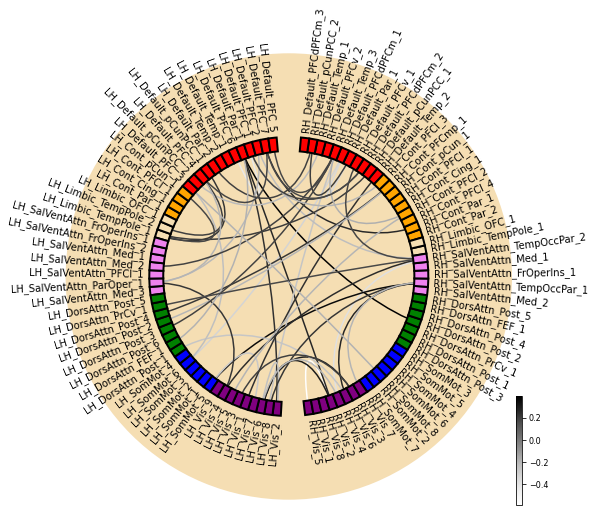

(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

In [487]:
i_1 = []
i_2 = []
for f in range(len(df)):
    feature = df.iloc[f,:]
    i_1.append(node_names.index(feature['node1']))
    i_2.append(node_names.index(feature['node2']))
indices = (np.array(i_1), np.array(i_2))

lh_names = [name for name in node_names if 'LH' in name]
rh_names = [name for name in node_names if 'RH' in name]
lh_ordered = []
rh_ordered = []
net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
#net_names = net_list
for network in net_names: 
    lh_net_names = [name for name in lh_names if network in name]
    lh_ordered = lh_ordered + lh_net_names

    rh_net_names = [name for name in rh_names if network in name]
    rh_ordered = rh_ordered + rh_net_names
lh_ordered.reverse()
ordered = lh_ordered + rh_ordered

layout = circular_layout(node_names=node_names, node_order=ordered, group_boundaries=[0, len(lh_ordered)])
colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
#colors_list = color_list
#colors_list = [(120/255, 18/255, 133/255), (70/255, 130/255, 180/255), (0/255, 118/255, 14/255), (196/255, 57/255, 248/255), (220/255, 248/255, 162/255), (230/255, 146/255, 32/255), (204/255, 60/255, 78/255)]

color_dict = dict(zip(net_names, colors_list))
node_colors = []
for name in node_names:
    net = name.split('_')[1]
    node_colors.append(color_dict[net])
    

fig = plt.figure(figsize=[10,10], facecolor='white')
plot_connectivity_circle(con, node_names, indices ,fontsize_names=10, n_lines = 50,
                         textcolor='black', facecolor='wheat', node_angles=layout, 
                        node_colors=node_colors, fig=fig, colormap='Greys', colorbar=True) 

## Plot several graphs together

In [206]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)


#Plot results of all 3 tasks
dfs = ['df_DD', 'df_F', 'df_MC']

node_names_lis = []
con_lis = []
indices_lis = []
ordered_lis = []
node_colors_lis = []
layout_lis = []

for i in range(len(dfs)):
    path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/results/{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    node_names, con, indices, ordered, node_colors, layout = plot_con_helper.plot_con_helper(df)
    node_names_lis.append(node_names)
    con_lis.append(con)
    indices_lis.append(indices)
    ordered_lis.append(ordered)
    node_colors_lis.append(node_colors)
    layout_lis.append(layout)
    

In [207]:
layout_lis[1]

array([366.07142857, 317.5       , 222.5       , 218.45238095,
       238.69047619, 277.02380952, 214.4047619 , 321.54761905,
       169.88095238, 402.5       , 141.54761905, 301.30952381,
       357.97619048, 406.54761905, 137.5       , 234.64285714,
       210.35714286, 194.16666667, 410.5952381 , 133.45238095,
       414.64285714, 418.69047619, 157.73809524, 262.97619048,
       206.30952381, 341.78571429, 190.11904762, 230.5952381 ,
       258.92857143, 186.07142857, 362.02380952, 422.73809524,
       182.02380952, 254.88095238, 177.97619048, 370.11904762,
       305.35714286, 165.83333333, 281.07142857, 309.4047619 ,
       426.78571429, 173.92857143, 345.83333333, 374.16666667,
       430.83333333, 378.21428571, 129.4047619 , 325.5952381 ,
       382.26190476, 125.35714286, 121.30952381, 386.30952381,
       117.26190476, 390.35714286, 349.88095238, 202.26190476,
       394.4047619 , 434.88095238, 113.21428571, 285.11904762,
       198.21428571, 329.64285714, 153.69047619, 289.16

In [72]:
dfs = ['df_DD', 'df_F', 'df_MC']
df = dfs[0]
df

'df_DD'

<Figure size 432x288 with 0 Axes>

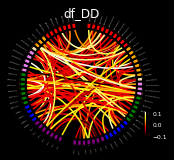

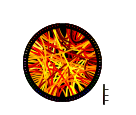

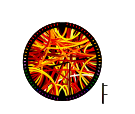

In [212]:
#Plot results of all 3 tasks
plt.tight_layout()
fig = plt.figure(num=None, figsize=(10, 5), facecolor='black')
#no_names = [''] * len(label_names)
for ii, df in enumerate(dfs):
    plot_connectivity_circle(con_lis[ii], node_names_lis[ii], indices_lis[ii] ,fontsize_names=0, n_lines=200,
                              textcolor='white', facecolor='black', node_angles=layout_lis[ii], 
                             node_colors=node_colors_lis[ii],
                             title=df, padding=0, fontsize_colorbar=6,
                             fig=fig, subplot=(2, 3, ii + 1))
     
plt.show()

# Find common edges between tasks

In [146]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)

dfs = ['df_DD', 'df_F']
df_arranged = {}
for i in range(len(dfs)):
    path = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/results/{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df_arranged[i] = plot_con_helper.arrange_df(df)



In [147]:
range(df_arranged[0].shape[0])


range(0, 123)

In [93]:
df_arranged[0].loc[0]['node1'].split('_')[1]

'DorsAttn'

In [148]:
df_arranged[0]

,Unnamed: 0,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,0,LH_Vis_1,RH_Cont_pCun_1,-0.048546,0.048546,Vis,Cont
1,1,LH_Vis_2,RH_Vis_1,0.034306,0.034306,Vis,Vis
2,2,LH_Vis_3,LH_DorsAttn_Post_3,-0.027305,0.027305,Vis,DorsAttn
3,3,LH_Vis_3,RH_Vis_7,-0.027874,0.027874,Vis,Vis
4,4,LH_Vis_3,RH_DorsAttn_Post_4,-0.035309,0.035309,Vis,DorsAttn
...,...,...,...,...,...,...,...
118,118,RH_Cont_Par_1,RH_Cont_PFCl_2,0.052396,0.052396,Cont,Cont
119,119,RH_Cont_PFCl_1,RH_Cont_PFCl_2,0.091222,0.091222,Cont,Cont
120,120,RH_Cont_Cing_1,RH_Default_Temp_2,0.045996,0.045996,Cont,Default
121,121,RH_Cont_Cing_1,RH_Default_Temp_3,0.032650,0.032650,Cont,Default


In [44]:
type(df_arranged[0])

pandas.core.frame.DataFrame

In [55]:
df_arranged[1]['node2'].split('_')[1] 

AttributeError: 'Series' object has no attribute 'split'

In [511]:
#Compare specific networks
key1 = 'df_WM'
key2 = 'df_DD'

res = []
for i in range(df_arranged[key1].shape[0]):
    #print(i)
    node1_val = df_arranged[key1].loc[i]['node1']
    node2_val = df_arranged[key1].loc[i]['node2']
    #print(node1_val)
    res_tmp = df_arranged[key2][(df_arranged[key2]['node1'] == node1_val) & (df_arranged[key2]['node2'] == node2_val)]
    if res_tmp.shape[0] == 0:
        res_tmp = df_arranged[key2][(df_arranged[key2]['node2'] == node1_val) & (df_arranged[key2]['node1'] == node2_val)]
    if res_tmp.shape[0] == 0:
        continue
    res.append([node1_val, node2_val])

In [512]:
res

[['LH_Vis_4', 'RH_Cont_PFCl_3'],
 ['LH_DorsAttn_PrCv_1', 'RH_SalVentAttn_TempOccPar_2'],
 ['LH_Default_Par_2', 'RH_Default_pCunPCC_2'],
 ['LH_Default_PFC_7', 'RH_Default_PFCdPFCm_2']]

In [ ]:
###### Compare only 7 networks
key1 = 'df_WM'
key2 = 'df_F'

res = []
for i in range(df_arranged[key1].shape[0]):
    #print(i)
    node1_org = df_arranged[key1].loc[i]['node1']
    node1_val = node1_org.split('_')[1]
    node2_org = df_arranged[key1].loc[i]['node2']
    node2_val = node2_org.split('_')[1]
    #print(node1_val)
    res_tmp = df_arranged[key2][(df_arranged[key2]['node1_nets'] == node1_val) & (df_arranged[key2]['node2_nets'] == node2_val)]
    if res_tmp.shape[0] == 0:
        continue
    res.append([node1_org, node2_org]) 

In [500]:
union = pd.concat([df_arranged[key1], df_arranged[key2]])

In [501]:
union

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Vis_2,LH_Vis_4,-0.182916,0.182916,Vis,Vis
1,LH_Vis_2,LH_Vis_5,-0.398821,0.398821,Vis,Vis
2,LH_Vis_2,RH_SalVentAttn_Med_1,0.101689,0.101689,Vis,SalVentAttn
3,LH_Vis_4,LH_SalVentAttn_PFCl_1,0.096027,0.096027,Vis,SalVentAttn
4,LH_Vis_4,LH_Default_PFC_2,-0.146710,0.146710,Vis,Default
...,...,...,...,...,...,...
118,RH_Cont_PFCl_2,RH_Default_Temp_3,0.394507,0.394507,Cont,Default
119,RH_Default_Par_1,RH_Default_PFCdPFCm_1,0.182004,0.182004,Default,Default
120,RH_Default_Par_1,RH_Default_pCunPCC_2,0.228514,0.228514,Default,Default
121,RH_Default_Temp_1,RH_Default_PFCdPFCm_1,0.098874,0.098874,Default,Default


In [491]:
unique_sum = union.groupby(['node1_nets', 'node2_nets'])
unique_sum

In [502]:
union.groupby(['node1', 'node2']).ngroups

242

In [510]:
len(res)

114

In [494]:
res

[['LH_DorsAttn_Post_1', 'LH_Default_Par_2'],
 ['LH_Cont_PFCl_1', 'LH_Default_PFC_3'],
 ['LH_Vis_2', 'LH_Vis_5'],
 ['RH_Default_Temp_1', 'RH_Default_pCunPCC_1'],
 ['LH_SalVentAttn_FrOperIns_1', 'RH_Cont_PFCl_3'],
 ['LH_Vis_5', 'RH_SalVentAttn_Med_1'],
 ['RH_DorsAttn_Post_4', 'RH_Cont_Par_1'],
 ['RH_DorsAttn_Post_4', 'RH_SalVentAttn_FrOperIns_1'],
 ['LH_Default_PFC_4', 'RH_Cont_Par_2'],
 ['RH_Default_Temp_3', 'RH_Default_PFCv_1'],
 ['LH_Default_PFC_2', 'RH_SomMot_8'],
 ['RH_Cont_Cing_1', 'RH_Default_PFCdPFCm_3'],
 ['LH_Cont_PFCl_1', 'RH_Vis_6'],
 ['LH_SomMot_5', 'LH_DorsAttn_Post_3'],
 ['LH_SomMot_5', 'RH_DorsAttn_Post_3'],
 ['RH_DorsAttn_Post_4', 'RH_Cont_PFCl_2'],
 ['RH_Vis_3', 'RH_Vis_4'],
 ['LH_Limbic_TempPole_2', 'RH_SalVentAttn_Med_1'],
 ['LH_Default_PFC_5', 'RH_Default_PFCv_2'],
 ['LH_Default_PFC_1', 'RH_Limbic_TempPole_1'],
 ['LH_Default_PFC_7', 'RH_Default_Temp_2'],
 ['LH_SomMot_6', 'RH_Cont_pCun_1'],
 ['RH_DorsAttn_Post_4', 'RH_SalVentAttn_TempOccPar_2'],
 ['RH_SalVentAttn_FrOp

In [18]:
node1_nets = []
for val in df_arranged[0]['node1']:
    #print(val)
    net = val.split('_')[1]
    node1_nets.append(net)
node1_nets



['ContC',
 'SalVentAttnA',
 'ContC',
 'ContC',
 'VisCent',
 'DefaultA',
 'DefaultA',
 'VisCent',
 'ContC',
 'ContC',
 'ContA',
 'ContA',
 'ContC',
 'SalVentAttnB',
 'VisCent',
 'DorsAttnA',
 'ContC',
 'DorsAttnA',
 'VisCent',
 'SalVentAttnB',
 'ContC',
 'SalVentAttnB',
 'ContC',
 'ContC',
 'ContA',
 'ContC',
 'SalVentAttnB',
 'DefaultA',
 'SalVentAttnA',
 'ContC',
 'DorsAttnB',
 'DorsAttnB',
 'DefaultB',
 'DorsAttnB',
 'SomMotA',
 'SalVentAttnA',
 'ContC',
 'SalVentAttnB',
 'DorsAttnB',
 'ContC',
 'ContC',
 'ContA',
 'DefaultC',
 'ContC',
 'ContA',
 'DorsAttnB',
 'ContC',
 'DorsAttnB',
 'VisPeri',
 'ContA']

In [67]:
df_arranged[0]['node1_nets'] = node1_nets

In [68]:
df_arranged[0]['node1_nets']

0            Cont
1     SalVentAttn
2            Cont
3            Cont
4             Vis
5         Default
6         Default
7             Vis
8     SalVentAttn
9            Cont
10       DorsAttn
11           Cont
12           Cont
13    SalVentAttn
14            Vis
15            Vis
16           Cont
17       DorsAttn
18            Vis
19    SalVentAttn
20           Cont
21    SalVentAttn
22           Cont
23           Cont
24           Cont
25           Cont
26    SalVentAttn
27        Default
28    SalVentAttn
29           Cont
30       DorsAttn
31       DorsAttn
32        Default
33       DorsAttn
34         SomMot
35    SalVentAttn
36           Cont
37           Cont
38       DorsAttn
39           Cont
40           Cont
41       DorsAttn
42            Vis
43           Cont
44       DorsAttn
45       DorsAttn
46           Cont
47       DorsAttn
48            Vis
49       DorsAttn
Name: node1_nets, dtype: object